In [12]:
import os

#cwd = os.getcwd()
cwd = '/home/proprietaire/Documents/Workspace/Jobs/Columbia/ultrametric_benchmark/Ultrametric-benchmark'

In [13]:
dataset = 'artificial_16'
nnarchi = 'FCL6'
seq_length = 100000
n_batches = 10
seq_genr_type = 'uniform'

# Foar artificial ultrametric dataset only
linear_ratio_for_artificial_seq = 8
artificial_seq_len = 200

In [14]:
os.chdir(cwd+'/Results')

dataroot = cwd+'/Results/' + dataset + '/' + nnarchi + '/' + seq_genr_type + '_length' + str(seq_length)+'_batches'+str(n_batches)
if 'artificial' in dataset:
    dataroot += '_seqlen'+str(artificial_seq_len)+'_ratio'+str(linear_ratio_for_artificial_seq)

In [15]:
# artificial_8 datapaths
datapaths = {
    ('artificial_8', 'FCL6', 'uniform', 'ratio_5'): 'T0.150_Memory0_block10_200116_235950',
    ('artificial_8', 'FCL10', 'uniform', 'ratio_5'): 'T0.150_Memory0_block10_200116_232209',
    ('artificial_8', 'FCL20', 'uniform', 'ratio_5'): 'T0.150_Memory0_block10_200116_225307',
    ('artificial_16', 'FCL6', 'uniform', 'ratio_8'): 'T0.150_Memory0_block1_200117_023332',
}

In this notebook, we'll loop through the files produced by the ultrametric framework accross temperatures and shuffle block size, and construct dictionnaries indexed by [T, blocksz].
We will then use those dicts to create the plots for DARPA.

Now let's load standard packages and find out about the content of each file:

In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pdb

from data_saver import ResultSet

import pickle
%matplotlib inline

In [18]:
datapaths[(dataset, nnarchi, seq_genr_type, 'ratio_'+str(linear_ratio_for_artificial_seq))]

'T0.150_Memory0_block1_200117_023332'

In [19]:
rs = ResultSet(dataroot, datapaths[(dataset, nnarchi, seq_genr_type, 'ratio_'+str(linear_ratio_for_artificial_seq))])
rs.load_analytics()

## Autocorrelation plots

Let's plot the autocorrelation function to DARPA standards:

In [23]:
from copy import deepcopy
import random

tree_l = 2**4
maxh = 2**19    
block_sizes = [1, 10, 100, 1000]
n_tests = 10

def shuffleblocks(seq, block_sz, snbr):
    lseq = len(seq)
    copied_seq = deepcopy(seq)
    sseq = []   # Will contain the shuffled sequence
    for k in range(snbr):
        begin, end = int(k*lseq/snbr), int((k+1)*lseq/snbr)
        bbegin, bend = int(begin/block_sz), int(end/block_sz)
        block_indices = [i for i in range(len(seq[:end])//block_sz)]
        random.shuffle(block_indices)
        for i in block_indices[bbegin:bend]:
            sseq += copied_seq[i*block_sz:(i+1)*block_sz]
    return sseq 

def get_atc(seq, blocks, snbr, T):
    tree_l = max(seq)+1
    plt.figure(1, figsize=(18,10))
    hlocs_stat = np.zeros(maxh-1)
    
    for i in range(tree_l):
        locs = np.array([j for j in range(len(seq)) if seq[j]==i])
        locss = deepcopy(locs)
        locss[:-1] = locss[1:]
        locsd = locss-locs
        bins = range(maxh)
        hlocs = np.histogram(locsd, bins, density=True)
        hlocs_stat = hlocs_stat + hlocs[0]/tree_l
        
    plt.loglog(
        bins[:-1],
        hlocs_stat,
        marker='.',
        ls = 'none',
        label='T={0:.2f} - Original sequence'.format(T)
    ) 
    for nfig, block_sz in enumerate(blocks):
        hlocs_stat = np.zeros(maxh-1)
        shuffleseq = shuffleblocks(seq, block_sz, snbr)
        #plt.figure(nfig+2)
        #plt.plot(shuffleseq)
        #plt.title(block_sz)
        for i in range(tree_l):
            locs = np.array([j for j in range(len(shuffleseq)) if shuffleseq[j]==i])
            locss = deepcopy(locs)
            locss[:-1] = locss[1:]
            locsd = locss-locs
            bins = range(maxh)
            hlocs = np.histogram(locsd, bins, density=True)
            hlocs_stat = hlocs_stat + hlocs[0]/tree_l
            
        plt.figure(1)    
        plt.loglog(
            bins[:-1],
            hlocs_stat,
            marker = '+',
            ls = 'none',
            label='T={0:.2f} - Shuffled with blocksz={1:d}'.format(T, block_sz),
            alpha=0.5) 
        plt.legend()

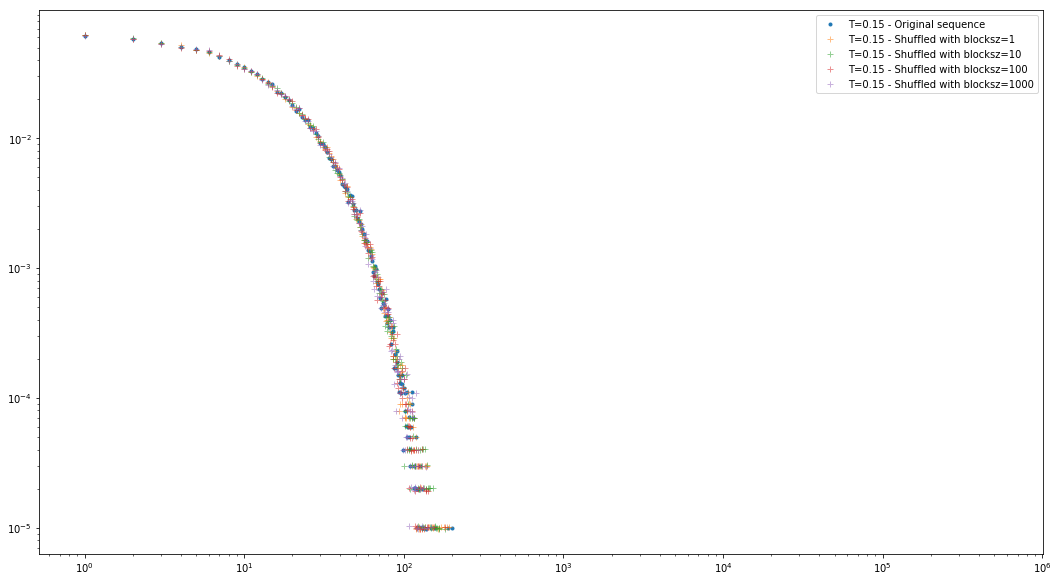

In [24]:
get_atc(rs.train_labels_orig, block_sizes, n_tests, T=0.15)

## Accuracy = f(t) plots

In [25]:
import pdb

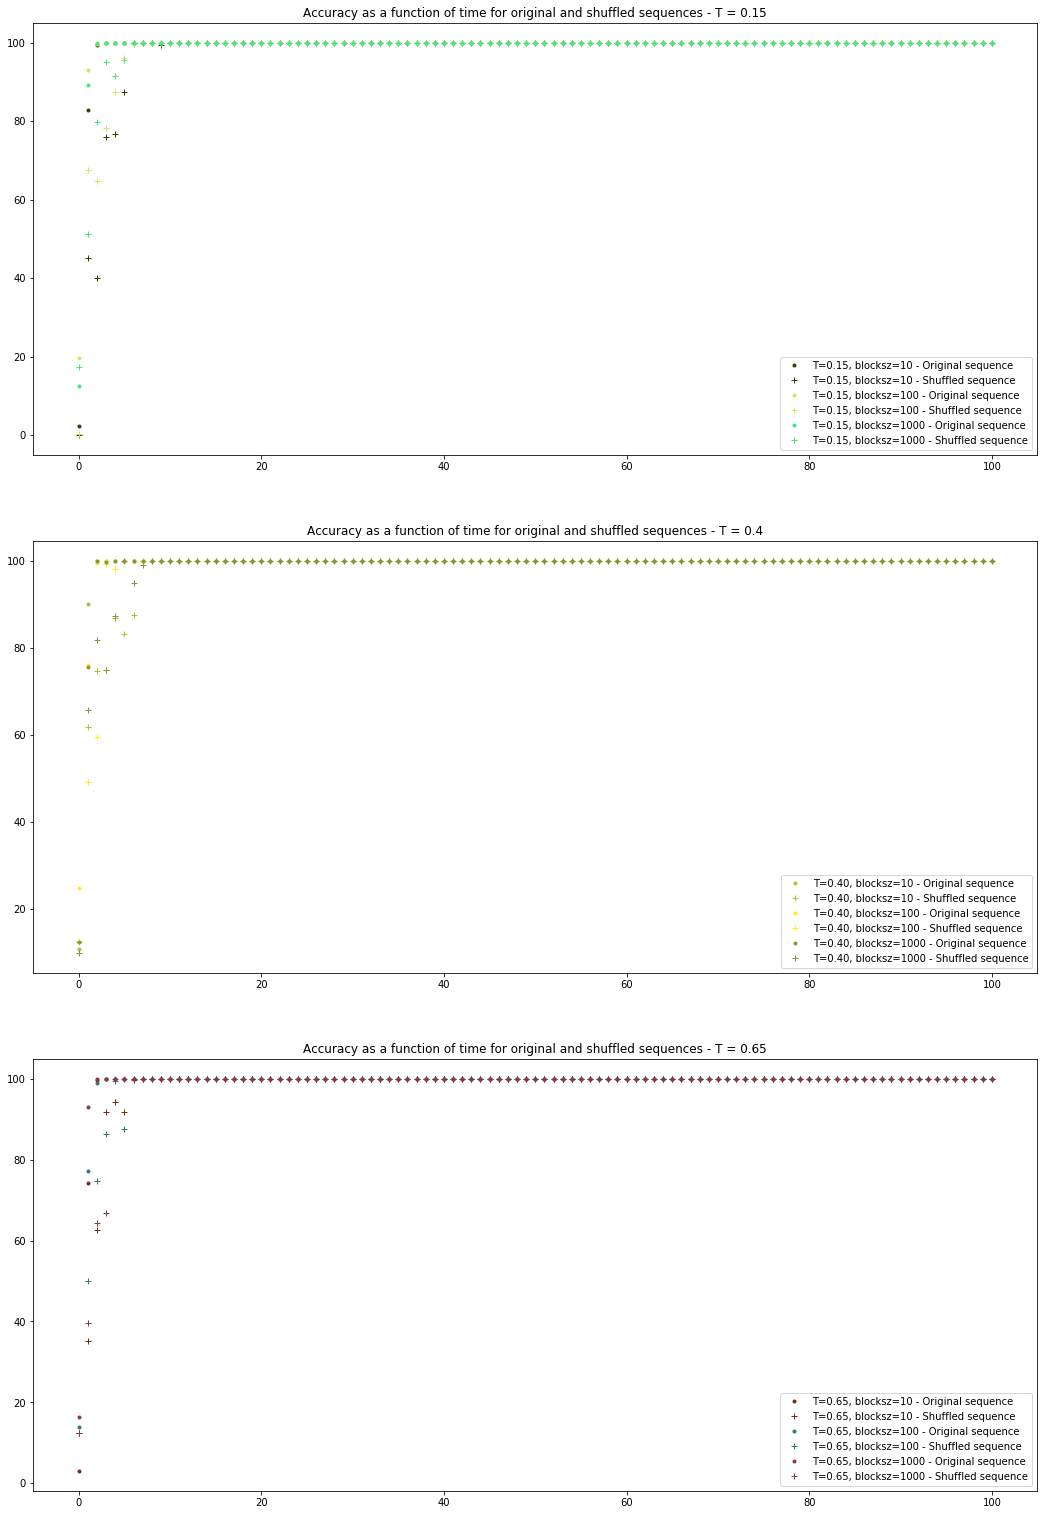

In [40]:
acc_fig = plt.figure(figsize=(18,9))
acc_ax = plt.subplot(111)
    
color = np.random.rand(3,)
    
acc_ax.plot(
    rs.var_acc_orig[params][:,0],
    marker = '.',
    ls = 'none',
    color = color,
    label='T={0:.2f}, blocksz={1:d} - Original sequence'.format(params[0], params[1])
)

acc_ax.plot(
    rs.var_acc_shfl[params][:,0],
    marker='+',
    ls = 'none',
    color = color,
    label='T={0:.2f}, blocksz={1:d} - Shuffled sequence'.format(params[0], params[1])
)
    
plt.title('Accuracy as a function of time for original and shuffled sequences - T = 0.15')
acc_ax.legend()


acc_ax = plt.subplot(312)

for params in [(0.4, 10), (0.4, 100), (0.4, 1000)]:
    
    color = np.random.rand(3,)
    
    acc_ax.plot(
        rs.var_acc_orig[params][:,0],
        marker = '.',
        ls = 'none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Original sequence'.format(params[0], params[1])
    )

    acc_ax.plot(
        rs.var_acc_shfl[params][:,0],
        marker='+',
        ls = 'none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Shuffled sequence'.format(params[0], params[1])
    )
    
plt.title('Accuracy as a function of time for original and shuffled sequences - T = 0.4')
acc_ax.legend()


acc_ax = plt.subplot(313)

for params in [(0.65, 10), (0.65, 100), (0.65, 1000)]:
    
    color = np.random.rand(3,)
    
    acc_ax.plot(
        rs.var_acc_orig[params][:,0],
        marker = '.',
        ls = 'none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Original sequence'.format(params[0], params[1])
    )

    acc_ax.plot(
        rs.var_acc_shfl[params][:,0],
        marker='+',
        ls = 'none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Shuffled sequence'.format(params[0], params[1])
    )
    
plt.title('Accuracy as a function of time for original and shuffled sequences - T = 0.65')
acc_ax.legend()